# Test Leading Frontier Models for Product Price Prediction :

In [1]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [ ]:
# Log in to HuggingFace

# hf_token = os.environ['HF_TOKEN']
# login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
# Log in to HuggingFace

import os
from dotenv import load_dotenv
from huggingface_hub import login

# Load .env file
load_dotenv()

# Get the token
hf_token = os.getenv("HF_TOKEN")

# ✅ Check if token loaded
if hf_token is None or hf_token.strip() == "":
    raise ValueError("❌ Hugging Face token not found. Please check your .env file.")
else:
    print("✅ Hugging Face token loaded successfully!")

# Login
login(hf_token, add_to_git_credential=True)

✅ Hugging Face token loaded successfully!


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from items import Item
from testing import Tester

In [5]:
openai = OpenAI()
claude = Anthropic()

In [6]:
%matplotlib inline

In [7]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

# Before we look at the Frontier

## There is one more model we could consider

In [8]:
# Write the test set to a CSV

import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [9]:
# Read it back in

human_predictions = []
with open('human_output.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [10]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

1: Guess: $120.00 Truth: $374.41 Error: $254.41 SLE: 1.28 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $80.00 Truth: $225.11 Error: $145.11 SLE: 1.05 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $35.00 Truth: $61.68 Error: $26.68 SLE: 0.31 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $350.00 Truth: $599.99 Error: $249.99 SLE: 0.29 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $75.00 Truth: $16.99 Error: $58.01 SLE: 2.08 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $12.00 Truth: $31.99 Error: $19.99 SLE: 0.87 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $115.00 Truth: $101.79 Error: $13.21 SLE: 0.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $100.00 Truth: $289.00 Error: $189.00 SLE: 1.11 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $300.00 Truth: $635.86 Error: $335.86 SLE: 0.56 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $80.00 Truth: $65.99 Error: $14.01 SLE: 0.0

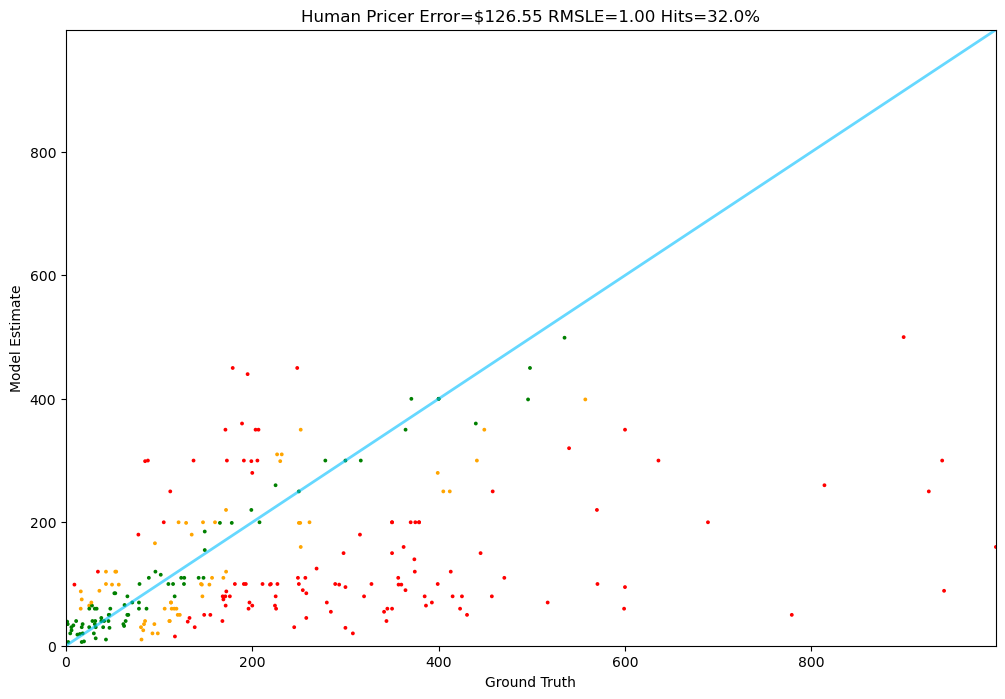

In [11]:
Tester.test(human_pricer, test)

## First, the humble but mighty GPT-4o-mini

It's called mini, but it packs a punch.

In [9]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"} # Provides extra context to aid the llm
    ]

In [ ]:
# def messages_for(item):
#     system_message = (
#         "You estimate the retail price of a single online product.\n"
#         "OUTPUT FORMAT: exactly 'Price is $<integer>' with no extra text, units, commas, or decimals.\n"
#         "CURRENCY: USD only.\n"
#         "ROUNDING: nearest dollar.\n"
#         "SCOPE: Use only product information provided in the user message (title, brand, category, features, specs, images-as-text if any).\n"
#         "IGNORE: any literal numbers that look like prices in the text (e.g., '$19.99', '€25'), shipping/taxes, coupons, lightning deals, and reviewer-stated prices.\n"
#         "ADJUSTMENTS:\n"
#         "- Brand tier and category typical bands (premium vs budget).\n"
#         "- Variant attributes (size/capacity/pack-count/material/year/model), set/kit/bundle multipliers.\n"
#         "- Condition keywords (new/refurb/used/for parts) and authenticity (official vs generic).\n"
#         "- If multiple variants are described, price the primary/most typical variant implied by the title.\n"
#         "SAFETY/BOUNDS: If clearly a low-ticket accessory, keep under 100. If clearly high-ticket electronics/appliances/furniture, allow above 100.\n"
#         "FALLBACK: If the item is too ambiguous, predict the most likely mainstream price for its brand+category archetype.\n"
#         "DO NOT: include explanations, currency codes, trailing punctuation, or newlines in the final answer."
#     )

#     # Your item.test_prompt() should contain the full product fields. We strip any trailing guidance.
#     user_prompt = (
#         item.test_prompt()
#             .replace(" to the nearest dollar", "")
#             .replace("\n\nPrice is $", "")
#     )

#     # Keep the same completion priming to match training data
#     return [
#         {"role": "system", "content": system_message},
#         {"role": "user", "content": user_prompt},
#         {"role": "assistant", "content": "Price is $"}
#     ]


In [10]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': "How much does this cost?\n\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"},
 {'role': 'assistant', 'content': 'Price is $'}]

In [11]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [12]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [12]:
# The function for gpt-4o-mini

def gpt_4o_mini(item):
    response = openai.chat.completions.create(
        model="gpt-4o-mini", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

In [ ]:
test[0].price

374.41

1: Guess: $250.00 Truth: $374.41 Error: $124.41 SLE: 0.16 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $50.00 Truth: $225.11 Error: $175.11 SLE: 2.22 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $40.00 Truth: $61.68 Error: $21.68 SLE: 0.18 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $400.00 Truth: $599.99 Error: $199.99 SLE: 0.16 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $25.00 Truth: $16.99 Error: $8.01 SLE: 0.14 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $20.00 Truth: $31.99 Error: $11.99 SLE: 0.20 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $50.00 Truth: $101.79 Error: $51.79 SLE: 0.49 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $300.00 Truth: $289.00 Error: $11.00 SLE: 0.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $300.00 Truth: $635.86 Error: $335.86 SLE: 0.56 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $60.00 Truth: $65.99 Error: $5.99 SLE: 0.01 It

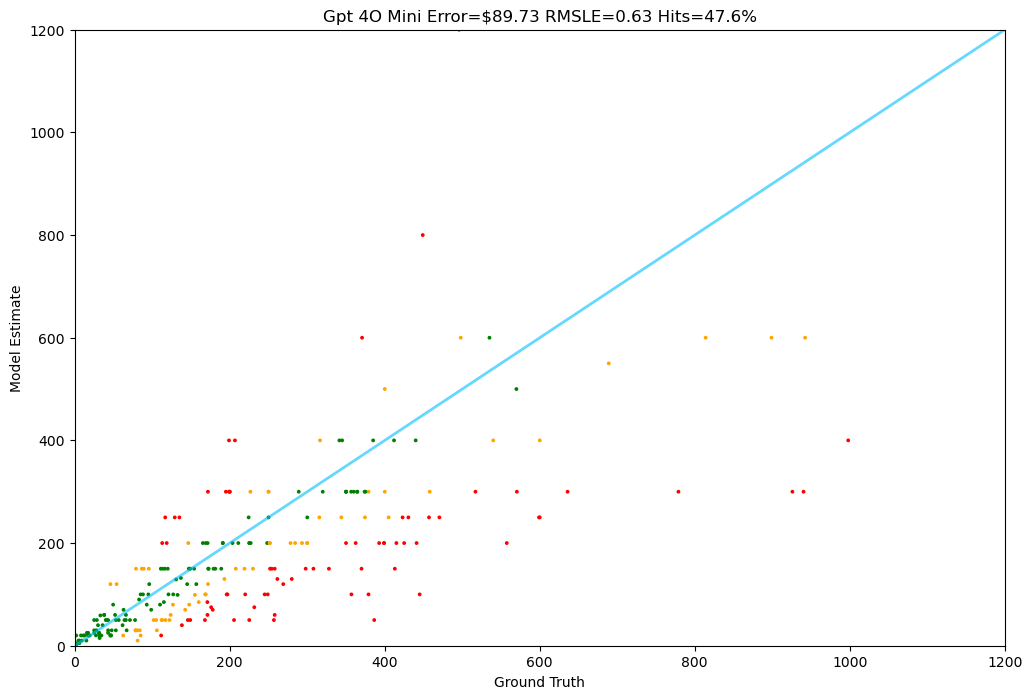

In [13]:
Tester.test(gpt_4o_mini, test)

In [13]:
def gpt_4o_frontier(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $280.00 Truth: $374.41 Error: $94.41 SLE: 0.08 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $75.00 Truth: $225.11 Error: $150.11 SLE: 1.19 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $30.47 Truth: $61.68 Error: $31.21 SLE: 0.47 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $429.99 Truth: $599.99 Error: $170.00 SLE: 0.11 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $23.47 Truth: $16.99 Error: $6.48 SLE: 0.09 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.00 Truth: $31.99 Error: $16.99 SLE: 0.52 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $110.00 Truth: $101.79 Error: $8.21 SLE: 0.01 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $399.00 Truth: $289.00 Error: $110.00 SLE: 0.10 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $500.00 Truth: $635.86 Error: $135.86 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $47.99 Truth: $65.99 Error: $18.00 SLE: 0.10 I

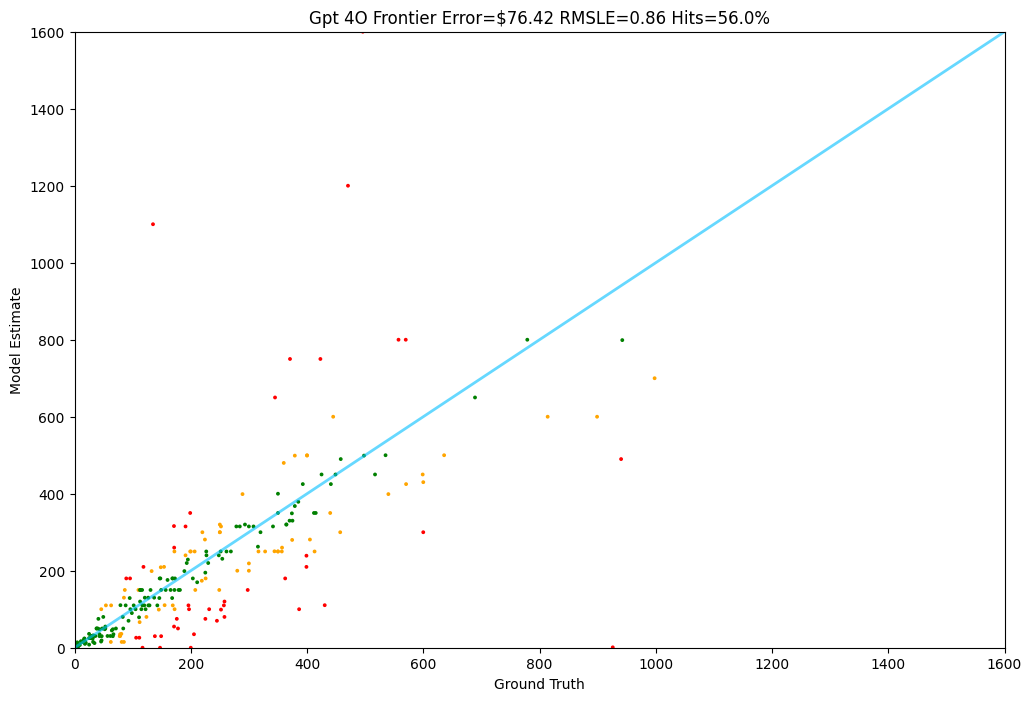

In [14]:
# The function for gpt-4o - the August model
# Note that it cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(gpt_4o_frontier, test)

In [15]:
def claude_3_point_5_sonnet(item):
    messages = messages_for(item)
    system_message = messages[0]['content']
    messages = messages[1:]
    response = claude.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=5,
        system=system_message,
        messages=messages
    )
    reply = response.content[0].text
    return get_price(reply)

In [ ]:
# The function for Claude 3.5 Sonnet
# It also cost me about 1-2 cents to run this (pricing may vary by region)
# You can skip this and look at my results instead

Tester.test(claude_3_point_5_sonnet, test)